In [90]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [91]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']

### Importing in GJ1243 light curve (DR-25)

In [92]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

### Masking out the flares

In [93]:
f_mask = np.zeros_like(gj1243lc.time, dtype=bool)
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 0.25
    c2 = 0.5  
    buffer = (gj1243lc.time >= t_starts[i] - c1*dur) & (gj1243lc.time <= t_stops[i] + c2*dur)
    temp = (gj1243lc.time >= t_starts[i]) & (gj1243lc.time <= t_stops[i])
    f_mask = f_mask + buffer
print(f_mask)
no_flares = np.where((f_mask == False))[0]

[False False False ... False False False]


Text(0.5, 0, 'Time - 2457000 [BTJD days]')

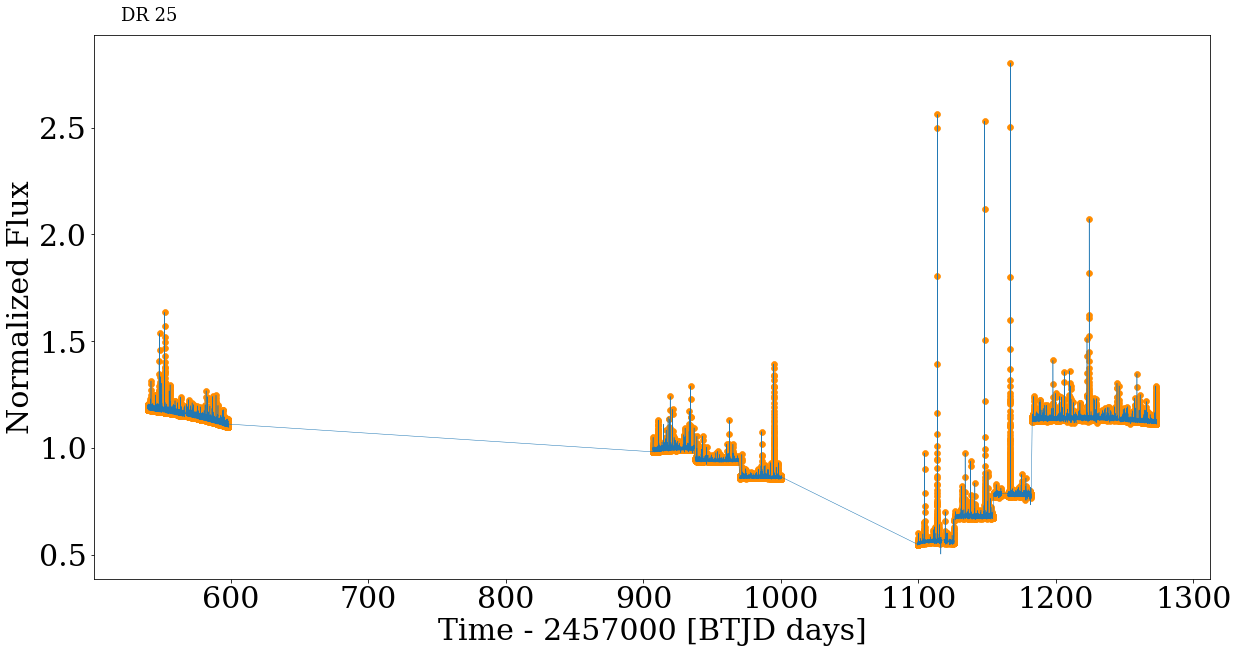

In [94]:
flares_x=gj1243lc.time[f_mask]
flares_y = gj1243lc.flux[f_mask]/np.nanmedian(gj1243lc.flux)

fig = plt.figure(figsize=(20,10))
import matplotlib
matplotlib.rcParams.update({'font.size':30})
matplotlib.rcParams.update({'font.family':'serif'})

fig.subplots_adjust(hspace=0.3, wspace=0.4)



plt.plot(gj1243lc.time[:84887],gj1243lc.flux[:84887]/np.nanmedian(gj1243lc.flux),linewidth=0.5,alpha=0.99,color='C0')
plt.plot(gj1243lc.time[84888:217976],gj1243lc.flux[84888:217976]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)
plt.plot(gj1243lc.time[217976:],gj1243lc.flux[217976:]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)


plt.scatter(flares_x,flares_y,linewidth=0.7,color='darkorange',s=35)



#Text
plt.text(520, 3, 'DR 25', fontsize=18, color ='k')


plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")


#plt.savefig('gj1243_keplerlc.pdf',dpi=300, bbox_inches='tight', pad_inches=0.5)

### Accounting for quarterly discontinuities

In [95]:
total_median = np.nanmedian(gj1243lc.flux[no_flares])
raw_flux = 1+((gj1243lc.flux - total_median)/total_median)

In [96]:
# arrays of start and stop times of each month of data
start_time = np.array([])
stop_time = np.array ([])
med_nf = np.array([])
for i in range(0,len(gj1243_collection)):
    try:
        month = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) & 
          (gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))[0]
        start = np.min(gj1243_collection[i].time)
        stop = np.max(gj1243_collection[i].time)
        med = np.nanmedian(gj1243lc.flux[no_flares][month])
        start_time = np.append(start_time,start)
        stop_time = np.append(stop_time,stop)
        med_nf = np.append(med_nf,med)
        
    except:
        print(i)

In [97]:
#Array of median fluxes across each month of data

medflux=np.array([])
for i in range(0,len(gj1243_collection)):
    try:
        
        month = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) & 
          (gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))[0]

        med = 1+((gj1243lc.flux[no_flares][month] - med_nf[i]))/total_median
        medflux = np.append(medflux,med)
    except:
            print(i)


### Running the Gaussian Process

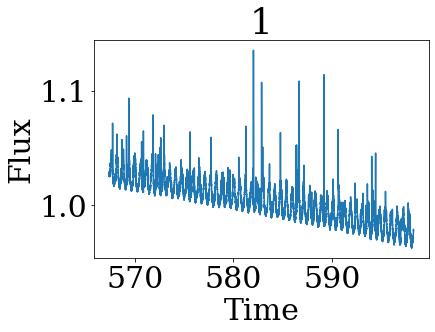

[nan nan nan ... nan nan nan]


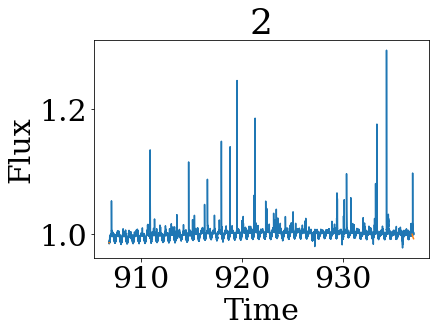

[0.98676198 0.98676309 0.98676421 ... 0.99323407 0.99320958 0.99318519]


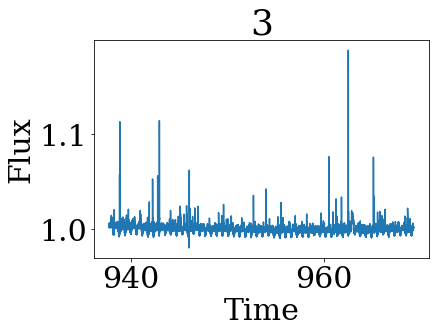

[nan nan nan ... nan nan nan]


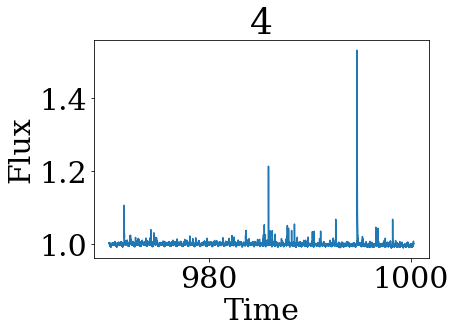

[nan nan nan ... nan nan nan]


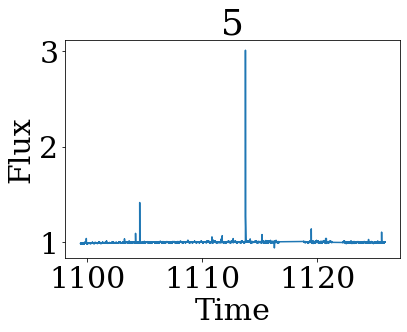

[nan nan nan ... nan nan nan]


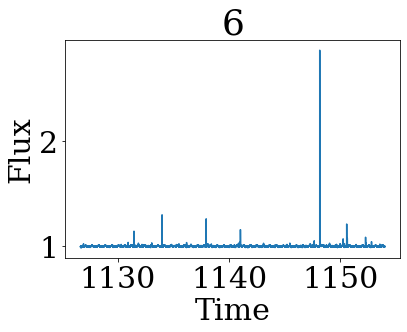

[0.99833035        nan        nan ...        nan        nan        nan]


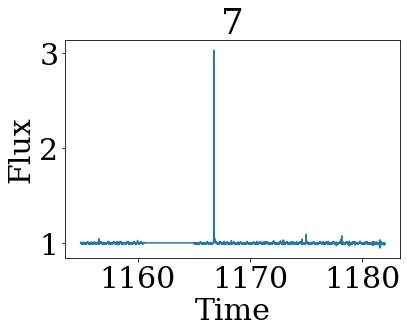

[nan nan nan ... nan nan nan]


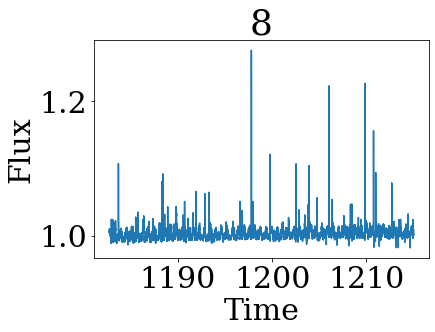

[nan nan nan ... nan nan nan]


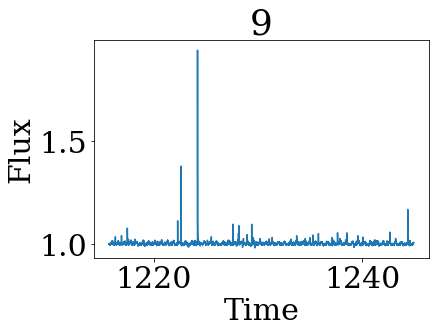

[nan nan nan ... nan nan nan]


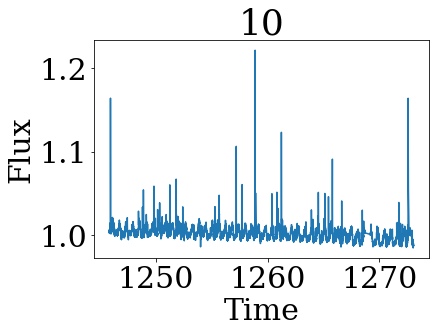

[nan nan nan ... nan nan nan]


In [12]:
import celerite
from scipy.optimize import minimize

for i in range (1,len(gj1243_collection)):
#         try:
        #month is the times of each month w/o flares
        month = np.where((gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) & 
                        (gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))[0]
        y = medflux[month]
        t = gj1243lc.time[no_flares][month]
        yerr = 1+((gj1243lc.flux_err[no_flares][month] - np.nanmedian(gj1243lc.flux[no_flares][month]))/(np.nanmedian(gj1243lc.flux[no_flares][month])))
        yerr = np.sqrt(yerr**2 + np.nanmedian(pd.Series(y).rolling(10,center=True).std())**2)
        Q = 0.001
        w0 = 2*np.pi/0.59
        S0 = np.var(y) / (w0 * Q)
        bounds = dict(log_S0=(-15,15), log_Q=(-15,15), log_omega0=(-15,15))
        kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)

        #Running the gp
        gp = celerite.GP(kernel, mean=np.mean(y),fit_mean=True)
        gp.compute(t, yerr)  # You always need to call compute once.

        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y)
        initial_params = gp.get_parameter_vector()
        bounds = gp.get_parameter_bounds()
        r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)


        month_flares = np.where((gj1243lc.time >= np.min(gj1243_collection[i].time)) & 
                                (gj1243lc.time <= np.max(gj1243_collection[i].time)))[0]
        x = gj1243lc.time[month_flares]
        pred_mean, pred_var = gp.predict(y, x, return_var=True)
        pred_std = np.sqrt(pred_var)

        #Saving each month of the gp run
        dict_i = {'time':x,'mean': pred_mean, 'std': pred_std, 'var': pred_var, 
                'detrended_flux':(1+((gj1243lc.flux[month_flares] - med_nf[i]))/total_median),
                'df_flux_err':(gj1243lc.flux[month_flares])/total_median}  
        gp_out = pd.DataFrame(data=dict_i) 
        gp_out.to_csv(r'gp_values_'+str(i)+'.csv',header=True,index=True)

        #plotting to make sure each month looks reasonable
        plt.figure()
        plt.plot(x,(1+((gj1243lc.flux[month_flares] - med_nf[i]))/total_median))
        plt.plot(x,pred_mean)
        plt.xlabel("Time")
        plt.ylabel("Flux")
        plt.title(str(i))
        plt.show()
        
        print(pred_mean)
            
            
#         except:
#             print(i)
#             plt.errorbar(t,y,yerr=yerr)
#             print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
#             print(r)


In [14]:
np.max(gj1243lc.flux[month_flares])

nan